In [1]:
# general imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

In [2]:
DATATYPE = "datetime64[ns]"
FORMAT = '%Y-%m-%d %H:%M:%S'
DECISION = ['M_WEATHER','M_RAIN_PERCENTAGE']
WINDOW_SIZE = 30

In [3]:
def clean(df):
    df = df[columns]
    df = df.dropna(subset=['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'])
    df = df[df['M_NUM_WEATHER_FORECAST_SAMPLES']!=0]
    df = df[df['M_TIME_OFFSET']==0.0]       
    df = df.drop(['M_TIME_OFFSET'], axis=1)
    df = df.drop_duplicates()
    return df

In [4]:
columns = [
            'TIMESTAMP',
            'M_SESSION_UID',
            'M_TRACK_ID',
            'M_TRACK_TEMPERATURE', #wywalone bo ma 98% korelacji z M_AIR_TEMP ~Rafał
            'M_FORECAST_ACCURACY', 
            'M_AIR_TEMPERATURE', 
            'M_NUM_WEATHER_FORECAST_SAMPLES', 
            'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_AIR_TEMPERATURE_CHANGE', 
            'M_RAIN_PERCENTAGE',
            'M_WEATHER',
            'M_TIME_OFFSET']

In [5]:
dataset_folder = "formulaaihackathon2022"
dataset_file = dataset_folder + "/weather.csv"

chunks = []

# for chunk in pd.read_csv(dataset_file, sep = ",", chunksize=10**6, low_memory=False):
    part = clean(chunk)
    chunks.append(part)

In [6]:
df = pd.concat(chunks)
print("After cleaning: ", str(len(df)))

After cleaning:  140615


In [7]:
df.head()

,TIMESTAMP,M_SESSION_UID,M_TRACK_ID,M_TRACK_TEMPERATURE,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER
17038,1.642724e+09,2939734289500381614,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0
17041,1.642724e+09,2939734289500381614,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0
17048,1.642724e+09,2939734289500381614,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17115,1.642724e+09,2939734289500381614,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0
17118,1.642724e+09,2939734289500381614,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0


(array([99887.,     0.,     0.,     0.,     0., 36905.,     0.,     0.,
            0.,  3823.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

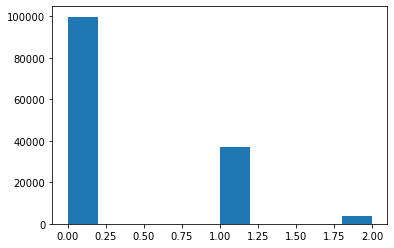

In [8]:
#histogram przed czyszczeniem danych
plt.hist(df['M_WEATHER'])

In [9]:
#seting column type
if(df['TIMESTAMP'].dtypes != DATATYPE):
    df['TIMESTAMP'] = df['TIMESTAMP'].apply(datetime.datetime.fromtimestamp)
df['M_SESSION_UID'] = df['M_SESSION_UID'].apply(int)

In [10]:
# df = pd.get_dummies(df, columns=['M_WEATHER'])

(array([99887.,     0.,     0.,     0.,     0., 36905.,     0.,     0.,
            0.,  3823.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

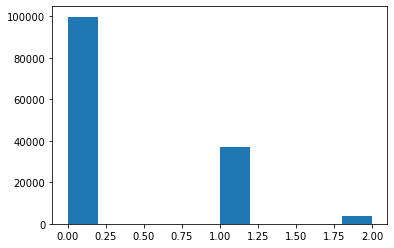

In [11]:
#histogram po czyszczeniu danych + wnioski: Z naszej analizy wynika, że sesje, gdzie M_WEATHER===5 to gry customowe, w któych gracz ustawił const wartrtosc M_WEATHER i to sprawdza ta kolumna: M_NUM_WEATHER_FORECAST_SAMPLES
plt.hist(df['M_WEATHER'])

((140585, 30, 2), (140585, 2))

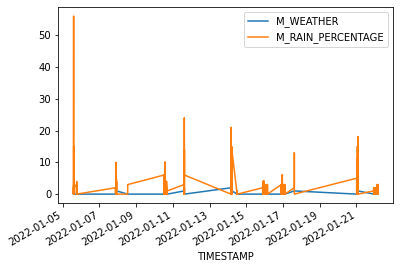

In [17]:
#LSTM - prepare data for models

df_1 = df.drop(['M_SESSION_UID'], axis=1)
df_2 = df.drop(['M_TRACK_ID'], axis=1)
df_3 = df.drop(['M_SESSION_UID', 'M_TRACK_ID'], axis=1)

df_1.index = pd.to_datetime(df_1['TIMESTAMP'], format=FORMAT)
df_2.index = pd.to_datetime(df_2['TIMESTAMP'], format=FORMAT)
df_3.index = pd.to_datetime(df_3['TIMESTAMP'], format=FORMAT)

#fun 
def df_to_X_y(df, window_size=30):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


temp = df_3[DECISION]
temp.plot()
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

In [13]:
# tf imports 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def generator(samples, batch_size=32, shuffle_data=True):
    """ Yields the next training batch."""
    num_samples = len(samples)
    while True: 
        shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]
            X_train = []
            y_train = []

            for batch_sample in batch_samples:
                img_name = batch_sample[0]
                label = batch_sample[1]
                X_train.append(img)
                y_train.append(label)

            X_train = np.array(X_train)
            y_train = np.array(y_train)
            
            yield X_train, y_train

In [20]:
# split to train validation
X_train, y_train = X[:105458], y[:105458] #105458 rows
X_val, y_val = X[105458:123034], y[105458:123034] #17576 rows
X_test, y_test = X[123034:], y[123034:] #17576 rows

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(105458, 30, 2) (105458, 2)
(17576, 30, 2) (17576, 2)
(17551, 30, 2) (17551, 2)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 19,298
Trainable params: 19,298
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_4 (Dense

In [ ]:
model1 = Sequential()
model1.add(InputLayer((12, 2)))
model1.add(LSTM(64))
model1.add(Dense(32, activation='tanh'))
model1.add(Dense(2))
model1.summary()

# we will monitor when to stop epochs, it depends on val_loss and it wont stop before 3 epochs no matter what
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.summary()

In [22]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stop])
# model1 = load_model('model1/')

Epoch 1/100
3296/3296 [==============================] - 111s 34ms/step - loss: 3.9546 - root_mean_squared_error: 1.9886 - val_loss: 4.1515 - val_root_mean_squared_error: 2.0375


2022-02-22 18:02:53.164304: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 2/100
2970/3296 [==========================>...] - ETA: 19s - loss: 2.2841 - root_mean_squared_error: 1.5113

KeyboardInterrupt: 

In [ ]:
# flatten to remove extra brackets
train_predictions = model1.predict(X_train)
print(train_predictions.shape)
print(y_train.shape)

In [ ]:
# INDEKSYYYYYYYY

In [ ]:
# we make a dataframe from results put in dict, and show it below
train_results = pd.DataFrame(data={'predicted_weather':train_predictions[:,[0,]].flatten(),
                                   'predicted_rain_percentage':train_predictions[:,[2,]].flatten(),
                                   'actual_weather':y_train[:,[1,]].flatten(),
                                   'actual_rain_percentage':y_train[:,[2,]].flatten()
                                  })
train_results

In [ ]:
# makind predictions on X_test data
test_predictions = model1.predict(X_test)

In [ ]:
# we make a dataframe from results put in dict, and show it below
test_results = pd.DataFrame(data={'predicted_weather':test_predictions[:,[0,]].flatten(),
                                   'predicted_rain_percentage':test_predictions[:,[1,]].flatten(),
                                   'actual_weather':y_test[:,[0,]].flatten(),
                                   'actual_rain_percentage':y_test[:,[1,]].flatten()
                                  })

test_results

In [ ]:
# Weather
test_results['predicted_weather'].plot()
test_results['actual_weather'].plot()

In [ ]:
# Rain probability
test_results['predicted_rain_percentage'][:20].plot()
test_results['actual_rain_percentage'][:20].plot()